In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout,Flatten,Conv2D,Input,MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Data generator

In [14]:
root_path = r"E:\deep_learning\skin_cancer\dataset\dataset"
img_width,img_height = 128,128
model_input = (img_width,img_height,3)
img_size = (img_width,img_height)
batch_size = 32

In [15]:


_datagen = ImageDataGenerator(
        rescale=1/255,
		width_shift_range=0.1,
		height_shift_range=0.1,
		horizontal_flip=True)

train_gen = _datagen.flow_from_directory(
    root_path+"/train",
    target_size = img_size,
    batch_size=batch_size,
    class_mode = "categorical"
)


test_gen = _datagen.flow_from_directory(
    root_path+"/test",
    target_size = img_size,
    batch_size=batch_size,
    class_mode = "categorical"
)

Found 2967 images belonging to 3 classes.
Found 330 images belonging to 3 classes.


#### Create model

In [16]:
from pyexpat import model
from statistics import mode


def create_model(input_size,kernel_size,num_filter,num_conv_layer,num_output):
    model = Sequential(Conv2D(num_filter,kernel_size = kernel_size,padding='same',activation = 'relu',input_shape =input_size ))
    for i in range(num_conv_layer):
        model.add(Conv2D(num_filter,kernel_size = kernel_size,padding='same',activation = 'relu'))
        model.add(Conv2D(num_filter,kernel_size = kernel_size,padding='same',activation = 'relu'))

        model.add(MaxPooling2D(2, 2))
        num_filter= num_filter+num_filter
    model.add(Flatten())
    model.add(Dense(units = num_output,activation = "softmax"))
    return model

#### Parameter and train

In [17]:
conv_layers = 2
num_filter = 32
kernel_size = (3,3)
num_train = len(train_gen.filenames)
num_test = len(test_gen.filenames)
steps_per_epoch=int(num_train / batch_size)

epochs =3


In [18]:
model = create_model(input_size= model_input,
                kernel_size = kernel_size,
                num_filter=num_filter,
                num_conv_layer = conv_layers,
                num_output=3)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 conv2d_33 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 conv2d_34 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_36 (Conv2D)          (None, 64, 64, 64)        36928     
                                                      

### Fine tune with mlflow

In [19]:
import mlflow
from google.cloud import storage

import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r'D:\gans\git_upload\ML-in-production\experiment-tracking\mlflow\mlflow_in_gcp\service-acc\credentials.json'
client = storage.Client()
mlflow.set_tracking_uri("http://34.172.170.236:5000/")
mlflow.set_experiment("ths-skin-cancer-experiment")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='ths-skin-cancer-experiment', tags={}>

In [20]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

import mlflow.tensorflow
from tensorflow.python.saved_model import signature_constants


In [21]:

key=signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY
key

'serving_default'

In [22]:
from mlflow.models.signature import infer_signature
import shutil
def objective(params):
    with mlflow.start_run():  
        mlflow.set_tag("developer","tharhtet")
        mlflow.log_params(params)


        model = create_model(input_size= model_input,
                kernel_size = params["kernel_size"],
                num_filter=params["filter_size"],
                num_conv_layer = params["conv_layers"],
                num_output=3)
        
        model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(lr=params["learning_rate"]),
                    metrics=['accuracy'])
        results = model.evaluate(test_gen , batch_size=batch_size)    
        mlflow.log_metric("val_loss", results[0])
        mlflow.log_metric("val_acc", results[1])

        test_img = None
        test_label = None
        for image,label in test_gen:
            test_img = image
            test_label = label
            break

        signature = infer_signature(test_img, model.predict(test_img))
        mlflow.keras.log_model(model, "model", signature=signature)
        artifact_path = mlflow.get_artifact_uri()
        print("Save to : ",artifact_path)
        #shutil.rmtree("skin_cancer_classification")
        mlflow.keras.save_model(model,"skin_cancer_classification")
            


      
        
    return {'loss' :results[0],'status':STATUS_OK }

        

In [23]:
conv_layers = 2
filters_size = [16,32,64]
kernel_sizes= [(3,3),(5,5),(7,7)]
learning_rate = 0.001
epochs =3



search_space = {
    "conv_layers" : scope.int(hp.quniform("conv_layers",2,4,1)),
    "filter_size" : scope.int(hp.choice("filter_size",filters_size)),
    "kernel_size" : hp.choice("kernel_size",kernel_sizes),
    "learning_rate" : hp.loguniform("learning_rate",-3,0),
    "epochs" : scope.int(hp.quniform("epochs",2,10,1))
    

}

In [24]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=1,
    trials=Trials()
)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\tharh\anaconda3\envs\tharhtet\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



11/11 [==============================] - 2s 121ms/step - loss: 1.1014 - accuracy: 0.3333

1/1 [==============================] - 0s 64ms/step 

  0%|          | 0/1 [00:04<?, ?trial/s, best loss=?]

c:\Users\tharh\anaconda3\envs\tharhtet\lib\site-packages\mlflow\keras.py:405: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input.
  warnings.warn(




INFO:tensorflow:Assets written to: C:\Users\tharh\AppData\Local\Temp\tmpvjtf3csi\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\tharh\AppData\Local\Temp\tmpvjtf3csi\model\data\model\assets



Save to :                                            
./mlruns/1/6c9782c227224792bc2eee78968783e9/artifacts
  0%|          | 0/1 [00:12<?, ?trial/s, best loss=?]

INFO:tensorflow:Assets written to: d:\gans\git_upload\ML-in-production\experiment-tracking\mlflow\mlflow_in_gcp\skin_cancer_classification\data\model\assets


INFO:tensorflow:Assets written to: d:\gans\git_upload\ML-in-production\experiment-tracking\mlflow\mlflow_in_gcp\skin_cancer_classification\data\model\assets



100%|██████████| 1/1 [00:21<00:00, 21.30s/trial, best loss: 1.101374626159668]


### ML flow model load and predict

In [25]:
logged_model = 'runs:/032ab3dc30194271afcb54c8effd2758/mnist_cnn'

In [26]:
tf_model = mlflow.keras.load_model(logged_model)
tf_model

RestException: RESOURCE_DOES_NOT_EXIST: Run '032ab3dc30194271afcb54c8effd2758' not found

(128, 128, 3)


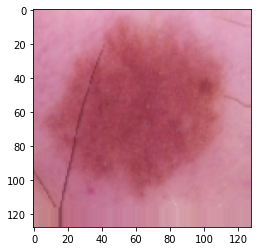

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
test_img = None
test_label = None
for image,label in test_gen:
    test_img = image[0]
    test_label = label[0]
    break
print(test_img.shape)
plt.imshow(test_img)


In [ ]:

img = np.array([test_img])
tf_model.predict(img,batch_size=1)

1/1 [==============================] - 1s 597ms/step


array([[0.33352116, 0.33142653, 0.33505228]], dtype=float32)

: 